In [1363]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.interpolate import interp1d

import numpy as np
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
tfd = tfp.distributions

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten

Num GPUs Available:  1


In [1364]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [1365]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

In [1366]:
# filter & duplicate drop from bayesian_nn
z_max = 4
filt = (photozdata['specz_redshift'] < z_max)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 100)\
&(photozdata['r_cmodel_mag'] < 100)\
&(photozdata['i_cmodel_mag'] < 100)\
&(photozdata['z_cmodel_mag'] < 100)\
&(photozdata['y_cmodel_mag'] < 100)\
&(photozdata['specz_flag_homogeneous'] == True)
photozdata.drop_duplicates(subset=['object_id'])
photozdata_subset = np.asarray(photozdata[filt])

In [1367]:
photozdata.columns

Index(['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'],
      dtype='object')

In [1368]:
random.shuffle(photozdata_subset)
# shuffle the data

In [1369]:
n = len(photozdata_subset)
test_size = int(n/5)

In [1370]:
X_total = list(photozdata_subset[:,[12,13,14,15,16]])
y_total = list(photozdata_subset[:,2])

In [1371]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_total)
X_total = scaler.transform(X_total)

In [1372]:
X_test = X_total[n - test_size : n]
y_test = y_total[n - test_size : n]

In [1373]:
Xy_total = np.transpose(np.vstack((np.transpose(X_total), y_total))).tolist()[0:n-test_size]
Xy_total_test = np.transpose(np.vstack((np.transpose(X_test), y_test))).tolist()[0:test_size]
# y on the last column
# Don't even think about touching the test set

In [1374]:
Xy_sorted= sorted(Xy_total, key=lambda x: x[5])
Xy_sorted_test= sorted(Xy_total_test, key=lambda x: x[5])

In [1375]:
strats = 8
Xy_strats = []
cur = z_max/strats
pre = 0
for i in range(0,n - test_size):
    if Xy_sorted[i][5] >= cur:
        Xy_strats.append(Xy_sorted[pre:i])
        pre = i
        cur += z_max/strats
    if i == n - test_size -1:
        Xy_strats.append(Xy_sorted[pre:i])
strat_length = []
for i in range(0,strats):
    random.shuffle(Xy_strats[i])
    strat_length.append(len(Xy_strats[i]))

In [1376]:
Xy_strats_test = []
cur = z_max/strats
pre = 0
for i in range(0,test_size):
    if Xy_sorted_test[i][5] >= cur:
        Xy_strats_test.append(Xy_sorted_test[pre:i])
        pre = i
        cur += z_max/strats
    if i == test_size -1:
        Xy_strats_test.append(Xy_sorted_test[pre:i])
test_length = []
for i in range(0,strats):
    random.shuffle(Xy_strats_test[i])
    test_length.append(len(Xy_strats_test[i]))

In [1377]:
count = 6 # number of networks, including the BNN

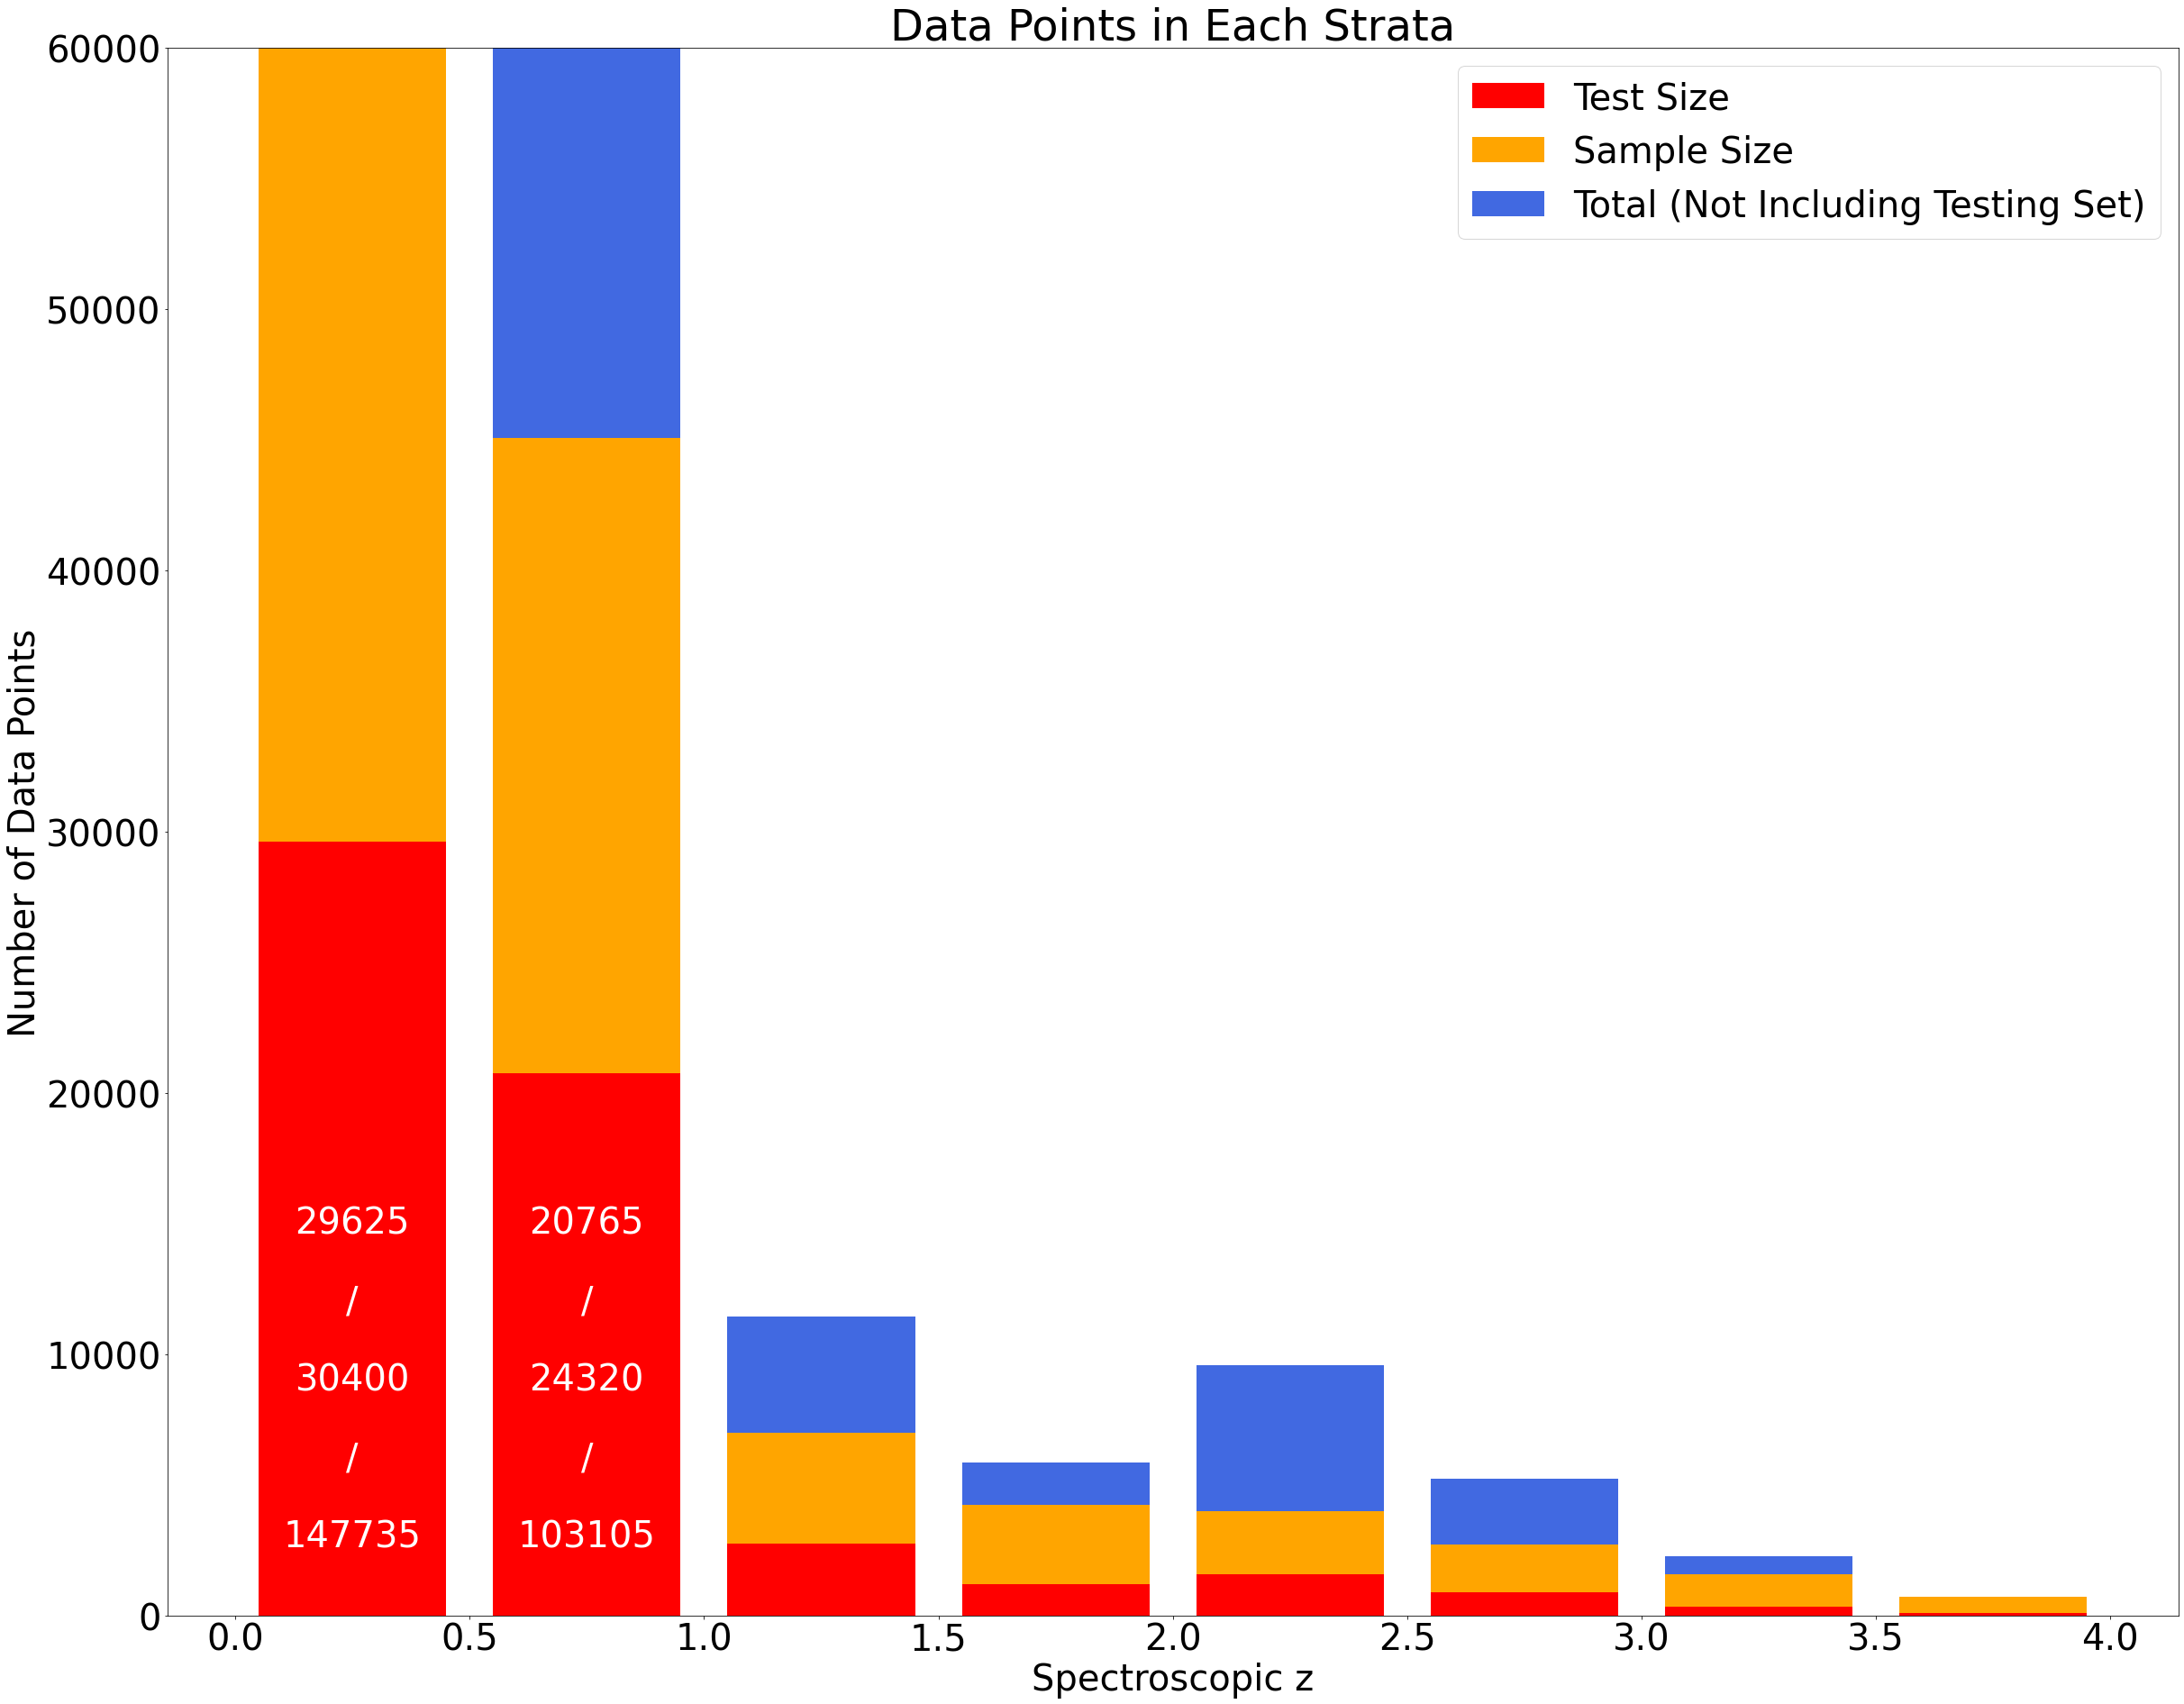

In [1378]:
# split data into 6/7 bins of training sets of 40000 and 1 bin of testing set of 6401
X = []
y = []

sample_array = [50, 40, 7, 5, 4, 3, 2, 1]
min_array = [np.min(strat_length), np.min(strat_length), np.min(strat_length), np.min(strat_length), np.min(strat_length), np.min(strat_length), np.min(strat_length), np.min(strat_length)] # sampling training data from each strat
sample_size_array = [a*b for a,b in zip(sample_array, min_array)]
sample_size_array_display = [sum(i) for i in zip(sample_size_array, test_length)]
total_strat_length = [sum(i) for i in zip(strat_length, test_length)]
bin_size = 8*sample_size # total amount of training data for each bin
z_ranges = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.figure(figsize=(40, 32))
plt.rcParams.update({'font.size': 40})
ax = plt.subplot(111)
ax.bar([i-0.25 for i in z_ranges], total_strat_length, width = 0.4, color = 'royalblue', label = 'Total (Not Including Testing Set)')
ax.bar([i-0.25 for i in z_ranges], sample_size_array_display, width = 0.4, color = 'orange', label = 'Sample Size')
ax.bar([i-0.25 for i in z_ranges], test_length, width = 0.4, color = 'red', label = 'Test Size')
plt.title('Data Points in Each Strata')
plt.xlabel('Spectroscopic z')
plt.ylabel('Number of Data Points')
ylim = 60000
plt.ylim([0,ylim])
plt.text(0.25, 1*ylim/20, str(total_strata_array[0]), color = 'white', size = 40, ha='center', va='center')
plt.text(0.75, 1*ylim/20, str(total_strata_array[1]), color = 'white', size = 40, ha='center', va='center')
plt.text(0.25, 2*ylim/20, "/", color = 'white', size = 40, ha='center', va='center')
plt.text(0.75, 2*ylim/20, "/", color = 'white', size = 40, ha='center', va='center')
plt.text(0.25, 3*ylim/20, str(sample_size_array[0]), color = 'white', size = 40, ha='center', va='center')
plt.text(0.75, 3*ylim/20, str(sample_size_array[1]), color = 'white', size = 40, ha='center', va='center')
plt.text(0.25, 4*ylim/20, "/", color = 'white', size = 40, ha='center', va='center')
plt.text(0.75, 4*ylim/20, "/", color = 'white', size = 40, ha='center', va='center')
plt.text(0.25, 5*ylim/20, str(test_length[0]), color = 'white', size = 40, ha='center', va='center')
plt.text(0.75, 5*ylim/20, str(test_length[1]), color = 'white', size = 40, ha='center', va='center')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()
for i in range(0, count):
    sampled = np.asarray(random.sample(Xy_strats[0], sample_size_array[0])).astype('float32')
    X_bin = sampled[:,[0,1,2,3,4]]
    y_bin = sampled[:,5]
    for j in range(1, strats):
        sampled = np.asarray(random.sample(Xy_strats[j], sample_size_array[j])).astype('float32')
        X_bin = np.concatenate((X_bin, sampled[:,[0,1,2,3,4]]), axis=0)
        y_bin =  np.concatenate((y_bin, sampled[:,5]), axis=0)
    X.append(X_bin)
    y.append(y_bin)

# X_test = np.asarray(X_total[3*bin_size : 3*bin_size + 5000]).astype('float32')
# y_test = np.asarray(y_total[3*bin_size : 3*bin_size + 5000]).astype('float32')

# X_pre = np.asarray(X_total[0 : pre]).astype('float32')
# y_pre = np.asarray(y_total[0 : pre]).astype('float32')

In [1379]:
models = []

for i in range(1,count):
    input_ = tf.keras.layers.Input(shape=X[0].shape[1:])
    hidden1 = tf.keras.layers.Dense(200, activation="tanh")(input_)
    hidden2 = tf.keras.layers.Dense(200, activation="tanh")(hidden1)
    hidden3 = tf.keras.layers.Dense(200, activation="tanh")(hidden2)
    hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
    # hidden5 = tf.keras.layers.Dense(200, activation="relu")(hidden4)
    # hidden6 = tf.keras.layers.Dense(200, activation="relu")(hidden5)
    concat = tf.keras.layers.Concatenate()([input_, hidden4])
    output = tf.keras.layers.Dense(1)(concat)
    model = tf.keras.Model(inputs=[input_], outputs=[output])
    model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])
    models.append(model)

input_ = tf.keras.layers.Input(shape=X[0].shape[1:])
hidden1 = tf.keras.layers.Dense(200, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
hidden5 = tf.keras.layers.Dense(200, activation="relu")(hidden4)
hidden6 = tf.keras.layers.Dense(200, activation="relu")(hidden5)
concat = tf.keras.layers.Concatenate()([input_, hidden6])
output = tf.keras.layers.Dense(1)(concat)
model_pre = tf.keras.Model(inputs=[input_], outputs=[output])
model_pre.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_pre.fit(X_pre,y_pre,epochs=50,shuffle = True,verbose=1)

In [1380]:
for i in range(0,count - 1):
    models[i].fit(X[i],y[i],epochs=50,shuffle = True,verbose=1)

Epoch 1/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2602 - mean_absolute_error: 0.2790
Epoch 2/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2288 - mean_absolute_error: 0.2529
Epoch 3/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2178 - mean_absolute_error: 0.2471
Epoch 4/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2100 - mean_absolute_error: 0.2438
Epoch 5/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2029 - mean_absolute_error: 0.2375
Epoch 6/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1925 - mean_absolute_error: 0.2280
Epoch 7/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1991 - mean_absolute_error: 0.2294
Epoch 8/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1933 - mean_absolute_error: 0.2235
Epoch 9/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1892 - mean_absolu

2128/2128 [==============================] - 3s 1ms/step - loss: 0.1795 - mean_absolute_error: 0.2072
Epoch 24/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1752 - mean_absolute_error: 0.2048
Epoch 25/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1655 - mean_absolute_error: 0.1959
Epoch 26/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1629 - mean_absolute_error: 0.1932
Epoch 27/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1625 - mean_absolute_error: 0.1932
Epoch 28/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1623 - mean_absolute_error: 0.1938
Epoch 29/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1585 - mean_absolute_error: 0.1897
Epoch 30/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1808 - mean_absolute_error: 0.2107
Epoch 31/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1669 - mean_absolute_

2128/2128 [==============================] - 3s 1ms/step - loss: 0.1485 - mean_absolute_error: 0.1807
Epoch 46/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1495 - mean_absolute_error: 0.1810
Epoch 47/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1502 - mean_absolute_error: 0.1821
Epoch 48/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1495 - mean_absolute_error: 0.1801
Epoch 49/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1489 - mean_absolute_error: 0.1799
Epoch 50/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1486 - mean_absolute_error: 0.1803
Epoch 1/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2627 - mean_absolute_error: 0.2783
Epoch 2/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2308 - mean_absolute_error: 0.2527
Epoch 3/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.2215 - mean_absolute_err

2128/2128 [==============================] - 3s 1ms/step - loss: 0.1697 - mean_absolute_error: 0.2023
Epoch 18/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1777 - mean_absolute_error: 0.2097
Epoch 19/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1720 - mean_absolute_error: 0.2041
Epoch 20/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1693 - mean_absolute_error: 0.2014
Epoch 21/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1691 - mean_absolute_error: 0.2013
Epoch 22/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1644 - mean_absolute_error: 0.1955
Epoch 23/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1628 - mean_absolute_error: 0.1956
Epoch 24/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1807 - mean_absolute_error: 0.2093
Epoch 25/50
2128/2128 [==============================] - 3s 1ms/step - loss: 0.1619 - mean_absolute_

y_predict_pre = []
for i in range(0,len(X_test)):
        predicted = model_pre.predict(np.array([X_test[i]]))
        y_predict_pre.append(float(predicted))

In [1381]:
y_predict = []

for i in range(0,count - 1):
    y_predict_single = models[i].predict(X_test)
    y_predict.append(np.transpose(y_predict_single)[0])

y_predict = np.transpose(y_predict)   
clear_output(wait=True)

In [1382]:
mean_array = []
std_array = []
for i in range(0,len(X_test)):
    mean = np.mean(y_predict[i])
    std = np.std(y_predict[i])
    mean_array.append(mean)
    std_array.append(std)

In [1383]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,mean_array])
z = gaussian_kde(xy)(xy)

xy_pre = np.vstack([y_test,y_predict_pre])
z_pre = gaussian_kde(xy_pre)(xy_pre)

fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, y_predict_pre, c = z_pre, s = 1, edgecolor = None)
plt.colorbar(scatter_plot)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 1], [0, 1],color = 'black')

In [1384]:
overlap = 0
overlap_array = []
for i in range(0,len(X_test)):
    if np.abs(y_test[i]-mean_array[i])<=std_array[i]:
        overlap += 1
        overlap_array.append(1)
    else:
        overlap_array.append(0)
print(overlap/len(X_test))

0.3684182960893855


In [1385]:
combined_array = np.transpose(np.vstack((y_test,mean_array,std_array,overlap_array)))

In [1386]:
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])

In [1387]:
bins = int(z_max*10)
splitted_sorted_combined_array = np.array_split(sorted_combined_array,bins)
coverage = []
for i in range(0,bins):
    bins_count = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        if splitted_sorted_combined_array[i][j][3] == 1:
            bins_count += 1
    coverage.append(bins_count/len(splitted_sorted_combined_array[i])/0.6827)
x_array = np.arange(0,z_max,z_max/bins)

In [1388]:
# from Evan's code, didn't completely understand this part
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [1389]:
input_variational = tf.keras.layers.Input(shape=X[count - 1].shape[1:])
hidden1_variational = tfp.layers.DenseVariational(200, activation='tanh', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(input_variational)
hidden2_variational = tfp.layers.DenseVariational(200, activation='tanh', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden1_variational)
hidden3_variational = tfp.layers.DenseVariational(200, activation='tanh', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden2_variational)
hidden4_variational = tfp.layers.DenseVariational(200, activation='relu', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden3_variational)   

concat_variational = tf.keras.layers.Concatenate()([input_variational, hidden4_variational])

distribution_params_variational = tf.keras.layers.Dense(units=2)(concat_variational)

output_variational = tfp.layers.IndependentNormal(1)(distribution_params_variational)

model_variational = tf.keras.Model(inputs=[input_variational], outputs=[output_variational])

model_variational.compile(optimizer='adam', loss=negative_loglikelihood,metrics=[keras.metrics.RootMeanSquaredError()])

In [1390]:
model_variational.fit(X[count - 1],y[count - 1], epochs=50, shuffle = True, verbose=1)

Epoch 1/50
2128/2128 [==============================] - 8s 3ms/step - loss: 14.8831 - root_mean_squared_error: 1.1685
Epoch 2/50
2128/2128 [==============================] - 7s 3ms/step - loss: 12.1366 - root_mean_squared_error: 1.1976
Epoch 3/50
2128/2128 [==============================] - 7s 3ms/step - loss: 11.1107 - root_mean_squared_error: 1.1698
Epoch 4/50
2128/2128 [==============================] - 7s 3ms/step - loss: 10.4801 - root_mean_squared_error: 1.1441
Epoch 5/50
2128/2128 [==============================] - 7s 3ms/step - loss: 9.7553 - root_mean_squared_error: 1.1012
Epoch 6/50
2128/2128 [==============================] - 7s 3ms/step - loss: 9.3772 - root_mean_squared_error: 1.0725
Epoch 7/50
2128/2128 [==============================] - 7s 3ms/step - loss: 8.8433 - root_mean_squared_error: 1.0504
Epoch 8/50
2128/2128 [==============================] - 7s 3ms/step - loss: 8.3807 - root_mean_squared_error: 1.0285
Epoch 9/50
2128/2128 [==============================] - 7s 3

In [1391]:
y_predict_variational = model_variational(X_test)

In [1392]:
y_predict_variational_mean = np.asarray(y_predict_variational.mean())[:,0]

In [1393]:
y_predict_variational_std = np.asarray(y_predict_variational.stddev())[:,0]

In [1394]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,len(X_test)):
    if np.abs(y_test[i]-y_predict_variational_mean[i])<=y_predict_variational_std[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)
print(overlap_variational/len(X_test))

0.8516061452513967


In [1395]:
combined_array_variational = np.transpose(np.vstack((y_test,y_predict_variational_mean,y_predict_variational_std,overlap_array_variational)))

In [1396]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [1397]:
bins_variational = int(z_max*10)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational,bins)
coverage_variational = []
for i in range(0,bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0,z_max,z_max/bins_variational)

In [1398]:
def bias(true, predicted):
    return (predicted - true)/(1 + true)

In [1399]:
bias_array = []
for i in range(0,test_size):
    bias_array.append(bias(y_test[i],mean_array[i]))

In [1400]:
combined_array_scatter = np.transpose(np.vstack((y_test,bias_array)))
sorted_combined_array_scatter = sorted(combined_array_scatter, key=lambda x: x[0])
bins_scatter = int(z_max*10)
splitted_sorted_combined_array_scatter = np.array_split(sorted_combined_array_scatter,bins_scatter)
scatter_array = []
for i in range(0,bins_scatter):
    scatter = np.std(splitted_sorted_combined_array_scatter[i])
    scatter_array.append(scatter)
x_array_scatter = np.arange(0,z_max,z_max/bins)
# plt.plot(x_array_scatter, scatter_array, c = 'red')
# plt.xlabel('spectroscopic redshift')
# plt.ylabel('scatter')
# plt.xlim([0,z_max])
# plt.ylim([0,2])

In [1401]:
combined_array_outlier = np.transpose(np.vstack((y_test,bias_array)))
sorted_combined_array_outlier = sorted(combined_array_outlier, key=lambda x: x[0])
bins_outlier = int(z_max*10)
splitted_sorted_combined_array_outlier = np.array_split(sorted_combined_array_outlier,bins_outlier)
outlier_array = []
for i in range(0,bins_scatter):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_array_outlier[i])):
        if np.abs(splitted_sorted_combined_array_outlier[i][j][1]) >= 1/4:
            outlier_count += 1
    outlier_array.append(outlier_count/test_size)
x_array_outlier = np.arange(0,z_max,z_max/bins)
# plt.plot(x_array_outlier, outlier_array, c = 'red')
# plt.xlabel('spectroscopic redshift')
# plt.ylabel('outlier count')
# plt.xlim([0,z_max])
# plt.ylim([0,10])

In [1402]:
bias_array_variational = []
for i in range(0,test_size):
    bias_array_variational.append(bias(y_test[i],y_predict_variational_mean[i]))

(0.0, 4.0)

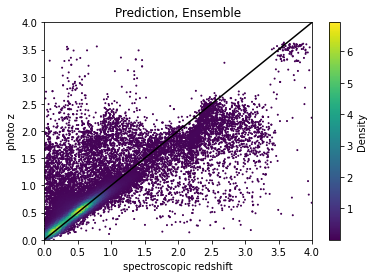

In [1414]:
import matplotlib.cm as cm
import matplotlib
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, mean_array, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction, Ensemble')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])

(0.0, 4.0)

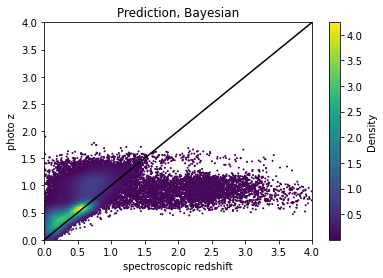

In [1415]:
xy_variational = np.vstack([y_test,y_predict_variational_mean])
z_variational = gaussian_kde(xy_variational)(xy_variational)
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, y_predict_variational_mean, c = z_variational, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])

Coverage: 0.3684182960893855


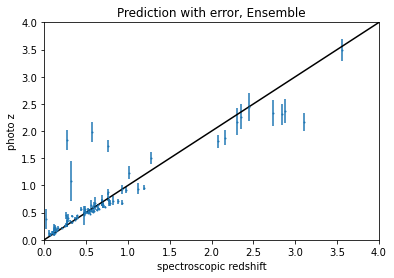

In [1416]:
fig, ax = plt.subplots()
error_plot = ax.errorbar(y_test[0:100], mean_array[0:100], yerr = std_array[0:100], fmt="o" ,markersize=1)
plt.title('Prediction with error, Ensemble')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap/len(X_test)))

Coverage: 0.8516061452513967


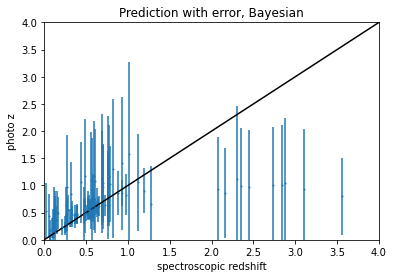

In [1417]:
fig, ax = plt.subplots()
error_plot = ax.errorbar(y_test[0:100], y_predict_variational_mean[0:100], yerr = y_predict_variational_std[0:100], fmt="o", markersize=1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_variational/len(X_test)))

Coverage: 0.3684182960893855


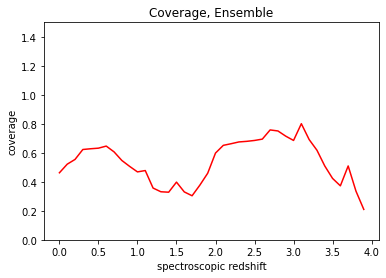

In [1418]:
plt.plot(x_array, coverage, c = 'red')
plt.title('Coverage, Ensemble')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0,1.5]) # 1.5 indicates full coverage
print("Coverage: "+str(overlap/len(X_test)))

Coverage: 0.8516061452513967


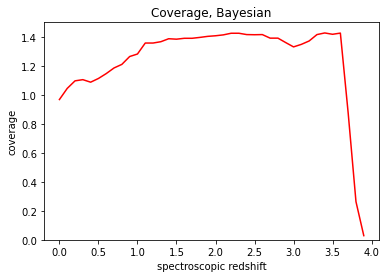

In [1419]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0,1.5]) # 1.5 indicates full coverage
print("Coverage: "+str(overlap_variational/len(X_test)))

(-1.0, 1.0)

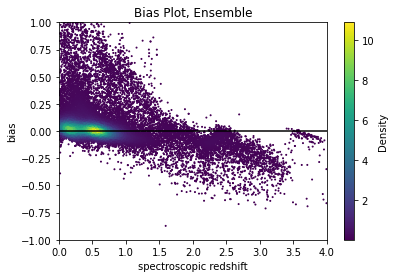

In [1420]:
xy_bias = np.vstack([y_test,bias_array])
z_bias = gaussian_kde(xy_bias)(xy_bias)
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, bias_array, c = z_bias, s = 1, edgecolor = None, label = 'Data')
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Bias Plot, Ensemble')
plt.xlabel('spectroscopic redshift')
plt.ylabel('bias')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.xlim([0, z_max])
plt.ylim([-1, 1])

(-1.0, 1.0)

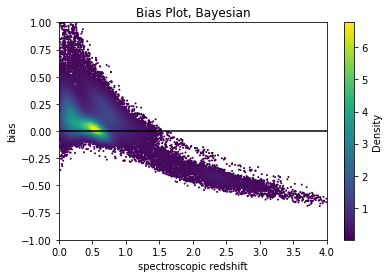

In [1421]:
xy_bias_variational = np.vstack([y_test,bias_array_variational])
z_bias_variational = gaussian_kde(xy_bias_variational)(xy_bias_variational)
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, bias_array_variational, c = z_bias_variational, s = 1, edgecolor = None, label = 'Data')
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Bias Plot, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('bias')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.xlim([0, z_max])
plt.ylim([-1, 1])

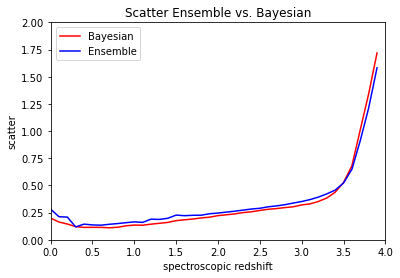

In [1422]:
combined_array_scatter_variational = np.transpose(np.vstack((y_test,bias_array_variational)))
sorted_combined_array_scatter_variational = sorted(combined_array_scatter_variational, key=lambda x: x[0])
bins_scatter_variational = int(z_max*10)
splitted_sorted_combined_array_scatter_variational = np.array_split(sorted_combined_array_scatter_variational,bins_scatter_variational)
scatter_array_variational = []
for i in range(0,bins_scatter_variational):
    scatter_variational = np.std(splitted_sorted_combined_array_scatter_variational[i])
    scatter_array_variational.append(scatter_variational)
x_array_scatter = np.arange(0,z_max,z_max/bins)
plt.plot(x_array_scatter, scatter_array_variational, c = 'red', label = 'Bayesian')
plt.plot(x_array_scatter, scatter_array, c = 'blue', label = 'Ensemble')
plt.title('Scatter Ensemble vs. Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('scatter')
plt.xlim([0,z_max])
plt.ylim([0,2])
plt.legend()

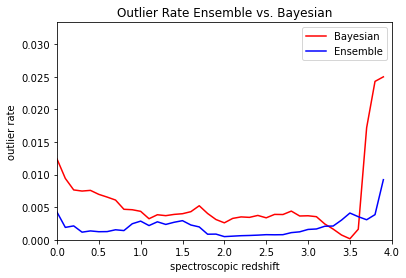

In [1423]:
combined_array_outlier_variational = np.transpose(np.vstack((y_test,bias_array_variational)))
sorted_combined_array_outlier_variational = sorted(combined_array_outlier_variational, key=lambda x: x[0])
bins_outlier_variational = int(z_max*10)
splitted_sorted_combined_array_outlier_variational = np.array_split(sorted_combined_array_outlier_variational,bins_outlier_variational)
outlier_array_variational = []
for i in range(0,bins_scatter_variational):
    outlier_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_outlier_variational[i])):
        if np.abs(splitted_sorted_combined_array_outlier_variational[i][j][1]) >= 1/4:
            outlier_count_variational += 1
    outlier_array_variational.append(outlier_count_variational/test_size)
x_array_outlier = np.arange(0,z_max,z_max/bins)
plt.plot(x_array_outlier, outlier_array_variational, c = 'red', label = 'Bayesian')
plt.plot(x_array_outlier, outlier_array, c = 'blue', label = 'Ensemble')
plt.title('Outlier Rate Ensemble vs. Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/30])
plt.legend()

In [1424]:
# END